In [158]:
# 필요 라이브러리 로딩
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm # 회귀분석

from statsmodels.tsa.stattools import adfuller # ADF는 정상성 검정을 위해 사용 
from statsmodels.tsa.seasonal import seasonal_decompose # 시계열 요소 분해 
# from statsmodels.tsa.arima_model import ARIMA # ARIMA 모델, SARIMA 모델 (삭제됨)
from statsmodels.tsa.arima.model import ARIMA # ARIMA 모델, SARIMA 모델
import pmdarima as pm # Auto ARIMA

## 정상성 vs 비정상성 

**정상성**: 정상성을 띄는 시계열은 해당 시계열이 관측된 시간과 무관 (즉, 시간에 따라 상승하거나 주기적인 변화가 있는 추세나 계절성이 없음)

특징
 - 정상 시계열은 평균이 일정
 - 분산이 시점에 의존하지 않음 
 - 공분산 또한 시점에 의존하지 않음(시차에는 의존)
 
정상성을 띄는 시계열은 장기적으로 예측 불가능한 시계열 (e.g 백색잡음 white noise가 대표적인 예)

**비정상성**: 시간에 영향을 받는 시계열(추세나 계절성이 있는 것이 대표적인 특징)

특징
 - 시간의 흐름에 따라 시계열의 평균 수준이 다름 
 - 시간의 흐름에 따라 추세를 가짐(우상향, 우하향 추세 등) 
 - 시간의 흐름에 따라 계절성이 있음
 - 시간의 흐름에 따라 시계열의 분산이 증가하거나 감소함

비정상성 시계열 예제) 여름에 아이스크림 판매량이 높고 겨율에 판매량이 낮다(계절성) 

## 정상 시계열 - 백색잡음(white noise)

In [159]:
# 정규분포에서 난수 365개 추출
np.random.seed(1)
x = np.random.randn(365)

원시계열 도표(Time Plot)

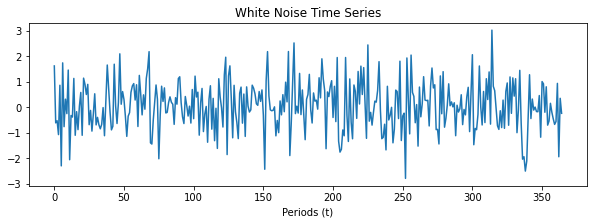

In [160]:
# 백색잡음 시도표
plt.figure(figsize=(10,3))

plt.plot(np.arange(365),x)
plt.title('White Noise Time Series')
plt.xlabel('Periods (t)')
plt.show()

## Augmented Dickey Fuller Test 단위근 검정 (ADF Test)

**Augmented Dicky fuller Test 가설검정**

- H0 : 정상성이 있는 시계열이 아님 (단위근)

- H1 : 정상성이 있는 시계열 

**귀무가설을 기각해야 정상성이 있는 시계열**

(엄밀히 말하면 ADF 검정 가설검정은)

$ H0 : seta = 0   vs   H1 : seta  < 0 $


In [161]:
# Augmented Dicky Fuller Test(adfuller)
result = adfuller(x)
result

(-19.772523202104033,
 0.0,
 0,
 364,
 {'1%': -3.4484434475193777,
  '5%': -2.869513170510808,
  '10%': -2.571017574266393},
 952.9340604979548)

- 결과: 귀무가설 기각 (p-value < 0.01) >> 정상 시계열

ACF 와 PACF

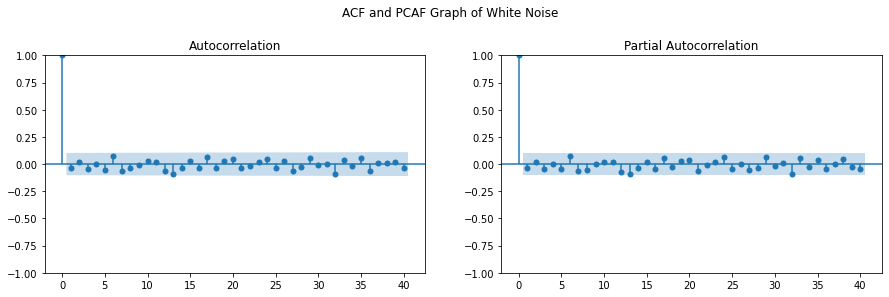

In [162]:
fig, axes = plt.subplots(1,2,figsize = (15,4))
fig = sm.graphics.tsa.plot_acf(x,lags=40, ax = axes[0])
fig = sm.graphics.tsa.plot_pacf(x,lags=40, ax = axes[1])
fig.suptitle('ACF and PCAF Graph of White Noise', y = 1.05)
plt.show()

백색 잡음 분포에는 자기상관 및 편자기상관 없음 --> 정상성

## 비정상성 시계열(추세 존재)

In [163]:
# 추세 생성 및 백색잡음에 추세 추가 
trend = np.linspace(1,15,365) # 추세 생성 
x_w_trend = x + trend # 백색잡음 x에 추세 

#### 원계열 시도표(Time plot)

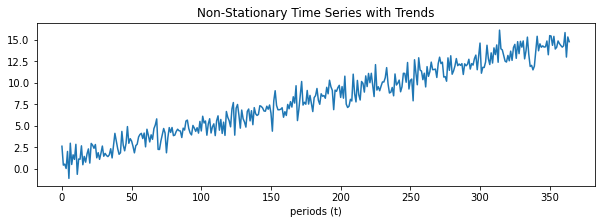

In [164]:
# 추세 존재 시계열의 도표 
plt.figure(figsize=(10,3))

plt.plot(np.arange(365), x_w_trend)
plt.title('Non-Stationary Time Series with Trends')
plt.xlabel('periods (t)')
plt.show()

## Augmented Dickey Fuller Test 단위근 검정 (ADF Test)

**Augmented Dicky fuller Test 가설검정**

- H0 : 정상성이 있는 시계열이 아님 (단위근)

- H1 : 정상성이 있는 시계열 

**귀무가설을 기각해야 정상성이 있는 시계열**


In [165]:
# 비정상 시계열에 대한 단위근 검정 결과 
result = adfuller(x_w_trend)
print('PDF stat: {: .4f}'.format(result[0]))
print('p-value: {: .4f}'.format(result[1]))
print('Critical Values : ')

for key , value in result[4].items():
    print('\t{}: {:.4f}'.format(key,value))

PDF stat: -0.7079
p-value:  0.8447
Critical Values : 
	1%: -3.4493
	5%: -2.8699
	10%: -2.5712


- 귀무가설을 기각할 수 없음 > 정상성을 만족 못하는 시계열 자료임 

### ACF 와 PACF

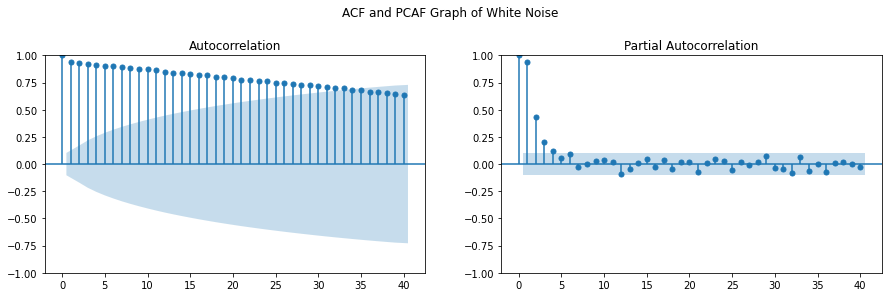

In [166]:
fig, axes = plt.subplots(1,2,figsize = (15,4))
fig = sm.graphics.tsa.plot_acf(x_w_trend,lags=40, ax = axes[0])
fig = sm.graphics.tsa.plot_pacf(x_w_trend,lags=40, ax = axes[1])
fig.suptitle('ACF and PCAF Graph of White Noise', y = 1.05)
plt.show()

자기상관은 시간이 흐를수록 줄어들고 & 부분자기상관은  시차 5번째 부터 파란색 음영 부분으로 들어옴

## ARIMA -- AR(5)

In [167]:
# statsmodels 가 제공하는 ARIMA 사용
arima_mod = ARIMA(x_w_trend, order=(5,0,0))# AR order만 5 따라서 AR(5) 인 모델

In [168]:
result = arima_mod.fit()

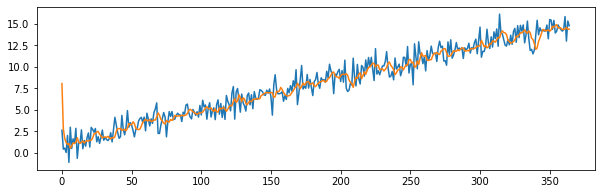

In [169]:
# 실 데이터 vs 모델 결과
plt.figure(figsize=(10,3))
plt.plot(np.arange(365),x_w_trend)
plt.plot(np.arange(365),result.fittedvalues)
plt.show()

In [170]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -545.109
Date:                Mon, 19 Aug 2024   AIC                           1104.217
Time:                        19:07:38   BIC                           1131.516
Sample:                             0   HQIC                          1115.066
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0428      5.053      1.592      0.111      -1.861      17.947
ar.L1          0.1981      0.048      4.106      0.000       0.104       0.293
ar.L2          0.2489      0.052      4.796      0.0

- Ljung-Box(Q) 통계량의 귀무가설: **"잔차(residual)는 백색잡음"**    (귀무가설 기각 불가)
- Jarque-Bera(JB) 통계량의 귀무가설: **"잔차(residual)는 정규성을 만족"** (귀무가설 기각 불가)

잔차가 정규성을 띈다면, skew는 0 , kurtosis는 3에 가까운 것이 특징 

[tip]
- **모집단**에서 구한 회귀식을 통해 얻은 예측값과 실제 관측값의 차이가 **오차**
- **표본집단**에서 구한 회귀식을 통해 얻은 예측값과 실제 관측값의 차이가 **잔차**

In [171]:
print('mean absolute error : {} '.format(result.mae))

mean absolute error : 0.8551272107074606 


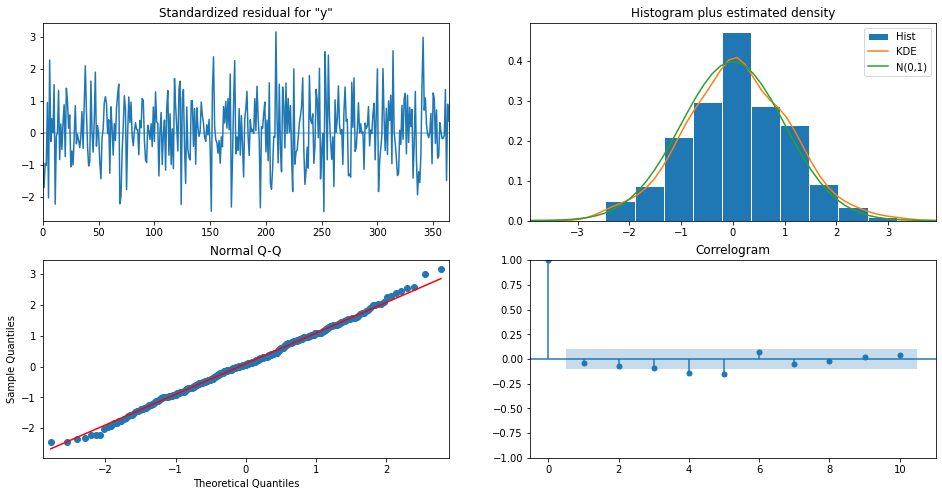

In [172]:
result.plot_diagnostics(figsize=(16,8)) # 등분산성 , 정규성 , 자기상관성 등을 파악할 수 있는 자료 제공
plt.show()

In [173]:
ar_5 = np.sum(np.abs(x_w_trend - result.fittedvalues))
ar_5

312.1214319082231

## ARIMA -- I(1)

In [174]:
# 차분만 이용한 추세제거 모델링(추세 요인은 차분으로 제거 가능)
arima_mod2 = ARIMA(x_w_trend, order = (0,1,0))
result = arima_mod2.fit()

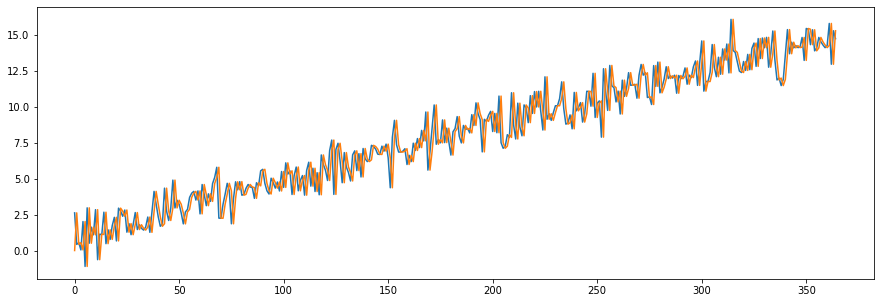

In [175]:
# 실 데이터 vs 모델 결과
plt.figure(figsize=(15,5))
plt.plot(np.arange(365),x_w_trend)
plt.plot(np.arange(365),result.fittedvalues)
plt.show()

In [176]:
i_1 = np.sum(np.abs(x_w_trend - result.fittedvalues))
i_1

398.3766694444225

In [177]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -634.642
Date:                Mon, 19 Aug 2024   AIC                           1271.284
Time:                        19:07:40   BIC                           1275.181
Sample:                             0   HQIC                          1272.833
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.9139      0.130     14.755      0.000       1.660       2.168
Ljung-Box (L1) (Q):                 100.83   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.00   Pr

- Ljung-Box(Q) 통계량의 귀무가설: **"잔차(residual)는 백색잡음"**    (귀무가설 기각)
- Jarque-Bera(JB) 통계량의 귀무가설: **"잔차(residual)는 정규성을 만족"** (귀무가설 기각 불가)

잔차가 정규성을 띈다면, skew는 0 , kurtosis는 3에 가까운 것이 특징 

In [178]:
print('mean absolute error {}'.format(result.mae))

mean absolute error 1.091442929984719


In [179]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(x_w_trend,result.fittedvalues)
print('mean absolute error :{}'.format(mae))

mean absolute error :1.091442929984719


In [180]:
pm.arima.auto_arima(x_w_trend,
                    d=1,
                    start_p=0,
                    max_p=5,
                    start_q=0,
                    max_q=5,
                    seasonal=False,
                    step=True,
                    trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1273.072, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1157.411, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1271.284, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1125.228, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1101.074, Time=0.52 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1092.347, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1071.004, Time=0.73 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.32 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1075.303, Time=0.10 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0] intercept
Total fit time: 8.876 seconds


ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [181]:
arima_mod3 = ARIMA(x_w_trend, order=(5,1,0))

In [182]:
result = arima_mod3.fit()

In [183]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -531.651
Date:                Mon, 19 Aug 2024   AIC                           1075.303
Time:                        19:07:49   BIC                           1098.686
Sample:                             0   HQIC                          1084.596
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8423      0.047    -17.886      0.000      -0.935      -0.750
ar.L2         -0.6425      0.069     -9.352      0.000      -0.777      -0.508
ar.L3         -0.5129      0.067     -7.630      0.0

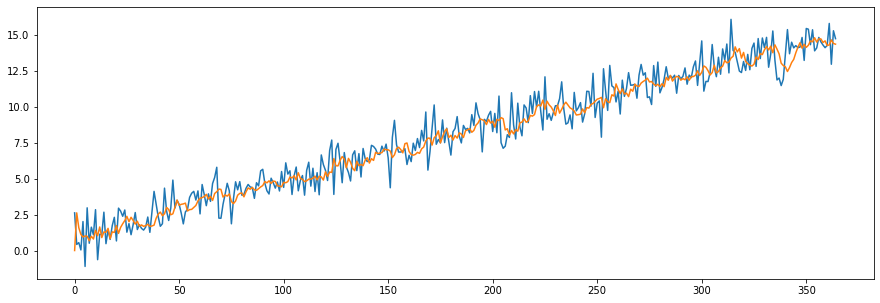

In [184]:
# 실 데이터 vs 모델 결과
plt.figure(figsize=(15,5))
plt.plot(np.arange(365),x_w_trend)
plt.plot(np.arange(365),result.fittedvalues)
plt.show()

In [185]:
print('mean absolute error : {} '.format(result.mae))

mean absolute error : 0.8300001366695912 


## 시계열 성분 분해(Time Series Decomposition)

In [186]:
# 날짜 범위 설정 (예: 2023년 1월 1일부터 2023년 6월 30일까지)
date_range = pd.date_range(start='2023-01-01', end='2023-06-30', freq='D')

# 168개 데이터 생성
data = {
    'year': date_range.year,
    'month': date_range.month,
    'date': date_range.day,
    'sales_amount': np.random.randint(50, 200, size=len(date_range))  # 50에서 200 사이의 랜덤 판매량
}

# DataFrame 생성
df = pd.DataFrame(data)

# 필요한 데이터 수만큼 선택 (예: 168개)
df['time'] = pd.to_datetime(df['year'].astype(str) +'-'+df['month'].astype(str)+'-'+df['date'].astype(str))

In [187]:
df = df.set_index('time',drop=True)
ts = df['sales_amount']

시도표(Time plot)

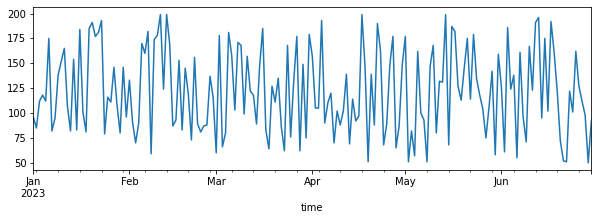

In [188]:
#시도표
ts.plot(figsize = (10,3))
plt.show()

시도표를 보며 생각해볼 점
1. 추세는 어떠한가? 우상향? 우하향
2. 계절성은 어떠한가? 반복되는 패턴이 있는가?
3. 분산은 어떠한가? 시간의 흐름에 상관없이 일정한가? 아니면 증가하는가?

ACF와 PACF 

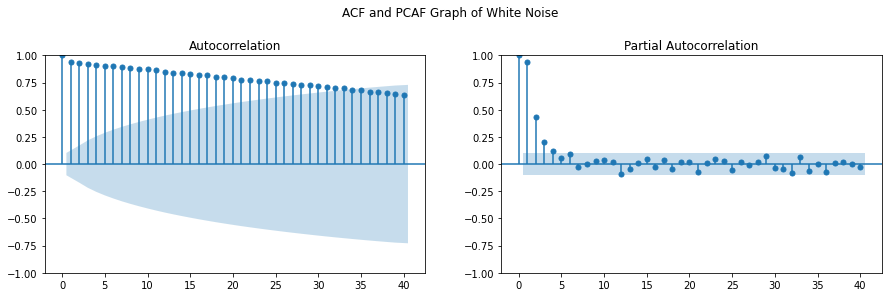

In [189]:
fig, axes = plt.subplots(1,2,figsize = (15,4))
fig = sm.graphics.tsa.plot_acf(x_w_trend,lags=40, ax = axes[0])
fig = sm.graphics.tsa.plot_pacf(x_w_trend,lags=40, ax = axes[1])
fig.suptitle('ACF and PCAF Graph of White Noise', y = 1.05)
plt.show()

계절성 분해(seasonal_decompose)

In [190]:
# statsmodel이 제공하는 seasonal_decompose 사용
decomp = seasonal_decompose(ts, model ='additive',period=12)

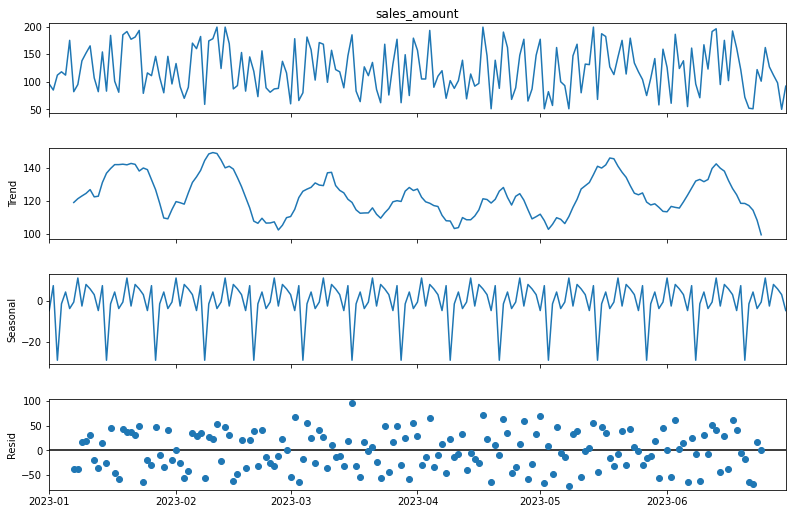

In [191]:
# 시계열 분해 그래프
fig =decomp.plot()
fig.set_size_inches((12,8))

- 분해후 남는 잔차(resid)를 살펴보자 시간의 흐름에 따라 동일한가? / 감소하는가?

In [192]:
decomp = seasonal_decompose(ts, model ='multiplicative',period=12)

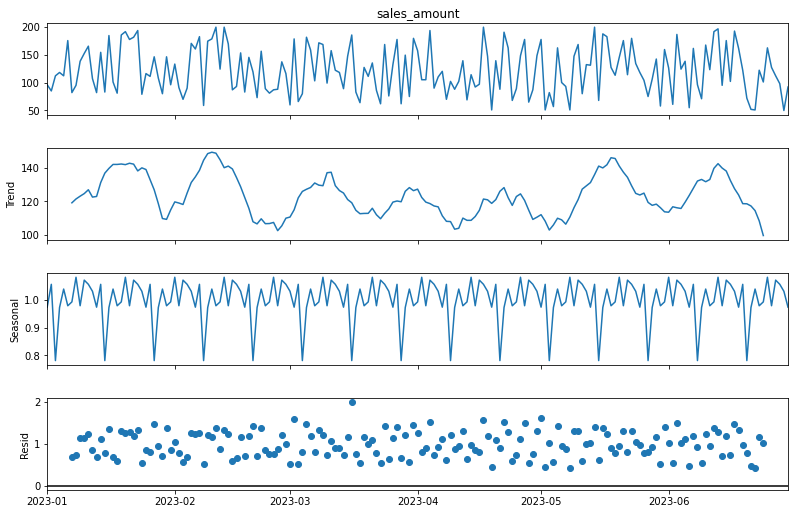

In [193]:
fig =decomp.plot()
fig.set_size_inches((12,8))

## SARIMAX: ARIMA + 계절성(S) = SARIMA

(참고 X는 Exogenous Varriable를 의미하며, 우리는 외생변수를 사용하지 않을것이기에 SARIMA 활용)

In [194]:
s_mod = sm.tsa.statespace.SARIMAX(ts,order=(1,1,0) , seasonal_order=(1,1,0,12))

c:\Users\Yang\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Yang\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [195]:
result = s_mod.fit()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       sales_amount   No. Observations:                  181
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -944.756
Date:                            Mon, 19 Aug 2024   AIC                           1895.512
Time:                                    19:07:56   BIC                           1904.884
Sample:                                01-01-2023   HQIC                          1899.316
                                     - 06-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4731      0.081     -5.832      0.000      -0.632      -0.314
ar.S.L12      -0.5677      0.066   

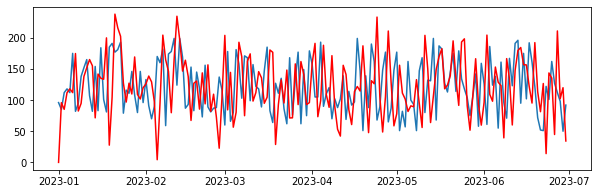

In [196]:
# 예측 그래프
plt.figure(figsize = (10,3))
plt.plot(ts)
plt.plot(result.fittedvalues,color='r')
plt.show()

In [197]:
pm.arima.auto_arima(x_w_trend,
                    d=1,
                    start_p=0,
                    max_p=5,
                    start_q=0,
                    max_q=5,
                    D= 1,
                    m = 12,# m=7: 일별/ m=52: 주별/  m=12 :월별
                    seasonal=False,
                    step=True,
                    trace=True)

c:\Users\Yang\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1273.072, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1157.411, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1271.284, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1125.228, Time=0.29 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1101.074, Time=0.23 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1092.347, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1071.004, Time=0.57 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.82 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1075.303, Time=0.08 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0] intercept
Total fit time: 9.168 seconds


ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

- 최적 모델 도출 (ARIMA(5,1,0)(0,0,0)[0] intercept)

In [201]:
s_mod = sm.tsa.statespace.SARIMAX(ts,order = (5,1,0), seasonal_order=(0,0,0,0))

c:\Users\Yang\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Yang\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [202]:
result = s_mod.fit()
print(result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         sales_amount   No. Observations:                  181
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -888.231
Date:                              Mon, 19 Aug 2024   AIC                           1792.461
Time:                                      19:08:43   BIC                           1817.453
Sample:                                  01-01-2023   HQIC                          1802.604
                                       - 06-30-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9028      0.074    -12.192      0.000      -1.048      -0.758
ar.L2         -0.81

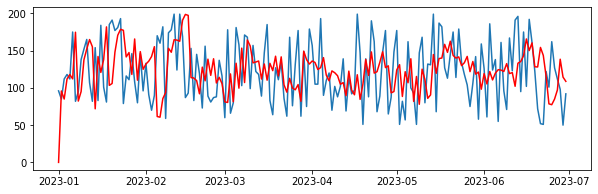

In [203]:
# 예측 그래프
plt.figure(figsize = (10,3))
plt.plot(ts)
plt.plot(result.fittedvalues,color='r')
plt.show()